# LAB 2_ CLASSIFICATION

### Rubric

#### Data Preparation (15 points total)
- Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.
- Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

### Modeling and Evaluation (70 points total)
- Choose and explain your evaluation metrics that you will use (i.e., accuracy,precision, recall, F-measure, or any metric we have discussed). Why are the measure(s)appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
- Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
- Create three different classification/regression models for each task (e.g.,random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!
- Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.
- Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.
- Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

### Deployment (5 points total)
- How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

### Exceptional Work (10 points total)

- You have free reign to provide additional analyses.
- One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

In [2]:
# Importing necessary packages for python
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression
import warnings
import matplotlib.pyplot as plt
import plotly.tools as tls

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', DeprecationWarning)
pd.set_option('mode.chained_assignment', None)

%matplotlib inline

In [3]:
# Importing data from Lab#1 and exploring the data, the csv file is the result dataset from Lab1
path = "../../Data/" # Generic path
incident = pd.read_csv(path + 'LAB1_completed_Dataset_clean.csv', low_memory= False)

In [4]:

# Exploying the dataset
incident['Response_time'] = incident['Response_time'].fillna(incident['Response_time'].mean()).astype(np.int)
incident = incident[incident['Call_Received_Hour'].isnull()==False]
incident_NullCols = incident.isnull().sum()
incident_NullCols = incident_NullCols[incident_NullCols > 0]

# Print out the data properties
# print(incident.shape)
# print('Number of null columns and their counts')
# print(incident_NullCols)

In [5]:

# Further cleanup the dataset
incident = incident[incident['Watch']!=0]
incident = incident[(incident['Victim_Age']>=0) & (incident['Victim_Age']<=90)]
incident = incident[incident['Victim_Race']!="Unknown"]
incident = incident[incident['Victim_Type']!="Unknown"]
incident= incident[incident.Number_of_offense != "RP"]

incident = incident[incident['Victim_Gender']!="U"]

In [6]:

# Further data clean up on the feature variables

incident.loc[:,'UCR_Offense_Name'] = incident['UCR_Offense_Name'].fillna("MISSING")

# Setup the UCR Offense Name Groups
THEFT_FRAUD     = dict.fromkeys(['THEFT/BMV', 'THEFT ORG RETAIL', 'BURGLARY-RESIDENCE', 'OTHER THEFTS',
                                 'ROBBERY-INDIVIDUAL','THEFT/SHOPLIFT', 'BURGLARY-BUSINESS', 'FORGE & COUNTERFEIT', 
                                 'FRAUD', 'EMBEZZLEMENT','ROBBERY-BUSINESS','THEFT ORG RETAIL'],"THEFT_FRAUD" ) 
MVA_TRAFFIC      =dict.fromkeys(['ACCIDENT MV', 'MOTOR VEHICLE ACCIDENT', 'UUMV', 'TRAFFIC VIOLATION',
                                 'TRAFFIC FATALITY'],"MVA_TRAFFIC" )        
WEAPONS_FIREARMS =dict.fromkeys(['WEAPONS', 'ARSON', 'INJURED FIREARM'], "WEAPONS_FIREARMS")         
ASSUALT          = dict.fromkeys(['ASSAULT','VANDALISM & CRIM MISCHIEF', 'AGG ASSAULT - NFV', 'OFFENSE AGAINST CHILD',
                                  'AGG ASSAULT - FV'], "ASSUALT")
OTHERS_THREATS   = dict.fromkeys(['FOUND', 'OTHERS', 'LOST', 'CRIMINAL TRESPASS', 'DISORDERLY CONDUCT', 
                                  'ANIMAL BITE','INJURED HOME','INJURED PUBLIC', 'TERRORISTIC THREAT', 
                                  'EVADING', 'INJURED OCCUPA', 'ORANIZED CRIME', 'KIDNAPPING', 
                                  'RESIST ARREST','FAIL TO ID', 'HUMAN TRAFFICKING', 'MISSING'], "OTHERS_THREATS")
INTOXICATION     = dict.fromkeys(['DRUNK & DISORDERLY', 'DWI', 'NARCOTICS & DRUGS', 'LIQUOR OFFENSE', 
                                  'INTOXICATION MANSLAUGHTER'],"INTOXICATION")
MURDER_DEATH     = dict.fromkeys(['SUDDEN DEATH&FOUND BODIES','MURDER'], "MURDER_DEATH")
                    
# Regroup the UCR_Offense_Name
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(THEFT_FRAUD)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MVA_TRAFFIC)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(WEAPONS_FIREARMS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(ASSUALT)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(OTHERS_THREATS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(INTOXICATION)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MURDER_DEATH)

In [7]:

# Change norminal attributes to numeric
incident.loc[:,'IsMale'] = incident.Victim_Gender=='M' 
incident.IsMale = incident.IsMale.astype(np.int)
incident.loc[:,'Social_crime_score'] = incident['Hate_Crime']+incident['Gang_Related_Offense']+incident['Drug_Related']
incident.loc[:,'Victim_Age'] = incident['Victim_Age'].astype(np.int)
incident.loc[:,'Number_of_offense']= incident.Number_of_offense.astype(np.int)
# coding
incident['UCR_Offense_Name'] = pd.Categorical(incident['UCR_Offense_Name']).codes
incident['Day1_of_the_Week'] = pd.Categorical(incident['Day1_of_the_Week']).codes
incident['Division'] = pd.Categorical(incident['Division']).codes
incident['Victim_Type'] = pd.Categorical(incident['Victim_Type']).codes
incident['Victim_Race'] = pd.Categorical(incident['Victim_Race']).codes

In [8]:
incident = incident.drop(['Year_of_Incident', 'Service_Number_ID', 'Type_of_Incident','Type_Location', 
                          'Reporting_Area', 'Beat', 'Sector','Council_District','Call_Received_Date_Time',
                          'Call_Cleared_Date_Time', 'Call_Dispatch_Date_Time','Person_Involvement_Type', 
                          'Victim_Gender', 'Offense_Status', 'Victim_Condition','Family_Offense', 'Weapon_Used', 
                          'RMS_Code', 'UCR_Code','X_Coordinate', 'Y_Coordinate', 'Zip_Code', 'City', 'State',
                          'Location1', 'Call_Received', 'Call_Cleared', 'Call_Dispatch','Latitude', 'Longitude'],axis=1)

Class 0: 202337
Class 1: 23115
Proportion: 8.75 : 1


<Figure size 576x360 with 0 Axes>

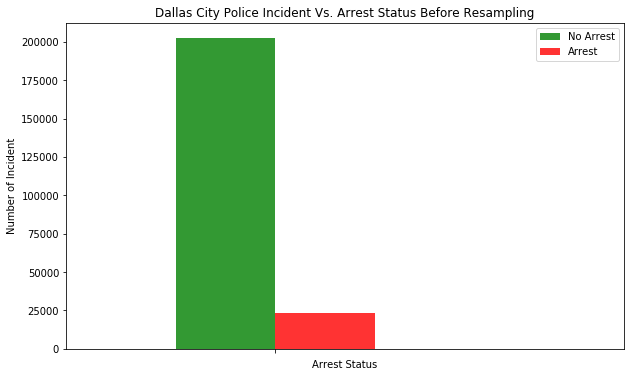

In [9]:
# Explore response variable distribution
plt.figure(figsize=(8,5))
target_count = incident.Arrest_status.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

# Draw bar plot

# data to plot
n_groups = 1
NoArrest=incident.Arrest_status.value_counts()[0]
Arrest=incident.Arrest_status.value_counts()[1]
 
# create plot
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, NoArrest, bar_width,
                 alpha=opacity,
                 color='g',
                 label='No Arrest')
 
plt.bar(index + bar_width, Arrest, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status Before Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
plt.show()

In [10]:
# Import resample package
from sklearn.utils import resample

# Downsampling
df_majority = incident[incident.Arrest_status==0]
df_minority = incident[incident.Arrest_status==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=23115,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Arrest_status.value_counts()

1    23115
0    23115
Name: Arrest_status, dtype: int64

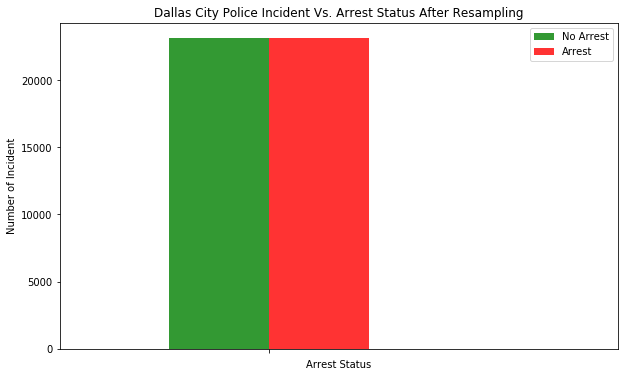

In [11]:
n_groups = 1
NoArrest=df_downsampled.Arrest_status.value_counts()[0]
Arrest=df_downsampled.Arrest_status.value_counts()[1]
 
# create plot
#ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, NoArrest, bar_width,
                 alpha=opacity,
                 color='g',
                 label='No Arrest')
 
plt.bar(index + bar_width, Arrest, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status After Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
#plt.tight_layout()
plt.show()

In [12]:
# copy the down sampling dataset to original incident data frame and continue the anl
incident= df_downsampled.copy()

In [13]:

#Create correlation matrix
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Social_crime_score  Drug_Related            0.842685
Call_Received_Hour  Watch                   0.712316
Social_crime_score  Gang_Related_Offense    0.562247
                    Hate_Crime              0.152233
Victim_Race         UCR_Offense_Name        0.131186
                                              ...   
Arrest_status       Victim_Race            -0.071456
UCR_Offense_Name    Watch                  -0.103933
Response_time       Arrest_status          -0.174816
Victim_Race         Division               -0.286416
UCR_Offense_Name    Arrest_status          -0.310592
Length: 120, dtype: float64


In [14]:
#Drop highly correlated, insignificant and high VIF columns.
incident = incident.drop(['Drug_Related','Watch','Gang_Related_Offense','Hate_Crime'], axis=1)

#Create correlation matrix
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Victim_Race         UCR_Offense_Name     0.131186
Social_crime_score  Number_of_offense    0.110633
Victim_Race         Victim_Age           0.106044
Number_of_offense   Arrest_status        0.081587
UCR_Offense_Name    Response_time        0.072490
                                           ...   
Arrest_status       Victim_Age          -0.067700
Victim_Race         Arrest_status       -0.071456
Arrest_status       Response_time       -0.174816
Division            Victim_Race         -0.286416
Arrest_status       UCR_Offense_Name    -0.310592
Length: 66, dtype: float64


In [15]:

# Y Response variable dataframe
inci_Y = incident['Arrest_status']

# Features with no predictive features with respect to resposne variable
incident = incident.drop(['Arrest_status'],axis=1)

In [16]:
# # Create inci_X Explanatory Variables DF to support the individual models
inci_X = incident
# inci_X = incident.drop(['Day1_of_the_Week', 'Victim_Race'], axis=1)
# inci_X_Rfe = incident
# inci_X_SVM = incident
# print("inci_X", inci_X.info())
# print("inci_X_Rfe", inci_X_Rfe.info())
# print("inci_X_SVM", inci_X_SVM.info())

In [17]:
from sklearn.preprocessing import StandardScaler

#Scale data
scaler = StandardScaler()
inci_X_scaled = scaler.fit_transform(inci_X)
# inci_X_Rfe_scaled = scaler.fit_transform(inci_X_Rfe)
# inci_X_SVM_scaled = scaler.fit_transform(inci_X_SVM)

#Save as data frames
df_inci_X_scaled = pd.DataFrame(inci_X_scaled)
# df_inci_X_Rfe_scaled = pd.DataFrame(inci_X_Rfe_scaled)
# df_inci_X_SVM_scaled= pd.DataFrame(inci_X_SVM_scaled)

In [18]:
# Credit: https://etav.github.io/

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(inci_X.values, i) for i in range(inci_X.shape[1])]
df2_vif["features"] = inci_X.columns
print("VIF Factors before Scaling")
df2_vif

VIF Factors before Scaling


,VIF Factor,features
0,3.823012,Division
1,3.180293,Day1_of_the_Week
2,28.176086,Victim_Type
3,5.835838,Victim_Race
4,8.471107,Victim_Age
5,2.435642,UCR_Offense_Name
6,5.083418,Number_of_offense
7,1.596640,Response_time
8,5.007212,Call_Received_Hour
9,2.184831,IsMale


In [19]:
# Credit: https://etav.github.io/

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(df_inci_X_scaled.values, i) for i in range(df_inci_X_scaled.shape[1])]
df2_vif["features"] = inci_X.columns
print("VIF Factors after Scaling")
df2_vif

VIF Factors after Scaling


,VIF Factor,features
0,1.093477,Division
1,1.001584,Day1_of_the_Week
2,1.001024,Victim_Type
3,1.122006,Victim_Race
4,1.022246,Victim_Age
5,1.031494,UCR_Offense_Name
6,1.017487,Number_of_offense
7,1.019102,Response_time
8,1.009191,Call_Received_Hour
9,1.014029,IsMale


In [20]:
# LOGISTIC REGRESSION: SUMMARY TABLE WITHOUT SCALING- FEATURE SIGNIFICANCE, CROSS VALIDATION OF FULL MODEL
from sklearn import metrics as mt
import statsmodels.api as sm
logit_model = sm.Logit(inci_Y, inci_X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.624114
         Iterations 6
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.100     
Dependent Variable:   Arrest_status    AIC:              57727.6014
Date:                 2018-10-10 20:54 BIC:              57823.7566
No. Observations:     46230            Log-Likelihood:   -28853.   
Df Model:             10               LL-Null:          -32044.   
Df Residuals:         46219            LLR p-value:      0.0000    
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       6.0000                                       
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Division            0.0057   0.0052   1.0983 0.2721 -0.0045  0.0160
Day1_of_the_Week    0.0063   0.0050   1.2

### Cross Validation 

In [21]:
from sklearn.model_selection import ShuffleSplit
# Create Cross Validation Object with 10 folds with 80/20 train - test split
cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)

In [24]:
inci_X.isnull().sum()

Division              0
Day1_of_the_Week      0
Victim_Type           0
Victim_Race           0
Victim_Age            0
UCR_Offense_Name      0
Number_of_offense     0
Response_time         0
Call_Received_Hour    0
IsMale                0
Social_crime_score    0
dtype: int64

In [25]:
inci_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46230 entries, 72724 to 255143
Data columns (total 11 columns):
Division              46230 non-null int8
Day1_of_the_Week      46230 non-null int8
Victim_Type           46230 non-null int8
Victim_Race           46230 non-null int8
Victim_Age            46230 non-null int32
UCR_Offense_Name      46230 non-null int8
Number_of_offense     46230 non-null int32
Response_time         46230 non-null int32
Call_Received_Hour    46230 non-null float64
IsMale                46230 non-null int32
Social_crime_score    46230 non-null int64
dtypes: float64(1), int32(4), int64(1), int8(5)
memory usage: 3.2 MB


In [28]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt


# create variables we are more familiar with
# X = inci_X
# y = inci_Y
X = inci_X.as_matrix().astype(np.float)
y = inci_Y.as_matrix().astype(np.float)
yhat = np.zeros(y.shape) # we will fill this with predictions

scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10)

# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=3)

# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('KNN accuracy', total_accuracy)

KNN accuracy 0.6160501838632922
Wall time: 1min 15s


In [33]:
%%time
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline

# setup pipeline to take PCA, then fit a KNN classifier
clf_pipe = Pipeline(
    [('PCA_Eric',PCA(n_components=11,svd_solver='randomized')),
     ('CLF_Eric',KNeighborsClassifier(n_neighbors=1))]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('KNN, pipeline accuracy', total_accuracy)

KNN, pipeline accuracy 0.5878866536880814
Wall time: 7.42 s


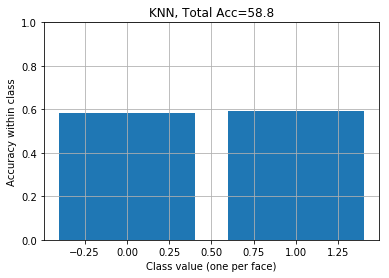

In [34]:
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (one per face)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
    
plot_class_acc(y,yhat,title="KNN")

Pipeline accuracy 0.6601557430240104


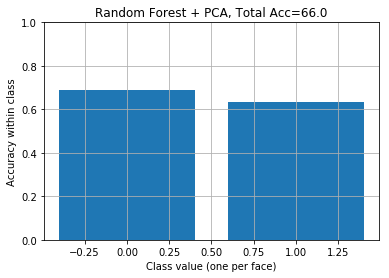

Wall time: 1min 58s


In [35]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_pipe = Pipeline(
    [('PCA',PCA(n_components=11, svd_solver='randomized')),
     ('CLF',RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1))]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print ('Pipeline accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Random Forest + PCA")

Accuracy 0.6667964525200086


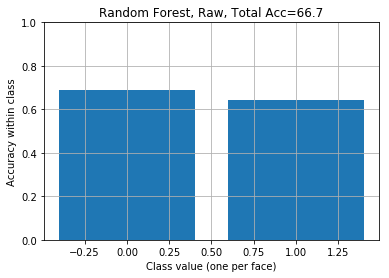

Wall time: 40.6 s


In [36]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Random Forest, Raw")

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


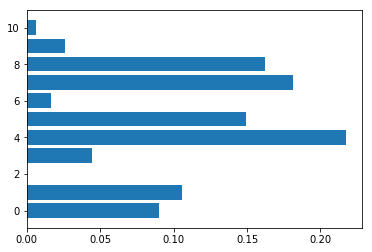

Generalization score estimate from training data 0.6770572966737166


In [37]:
# now lets get access to the different properties of our RF

print (clf)

plt.barh(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.show()

print ('Generalization score estimate from training data', clf.oob_score_)


# oob_SCORE - Very close to accuracy, represents data which are not just a guess and are not placed on the main data for ..
# ..do not use it as a replacement to cross validation

- Overall importance of each feature, magnitude of feature importance.

# TREE ENSEMBLE METHOD

In [38]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

num_estimators = 50
# lets train some trees
clf_array = [
    ('Stump',              DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)),
    ('Tree',               DecisionTreeClassifier()),
    ('Random Trees',       RandomForestClassifier(max_depth=50, n_estimators=num_estimators)),
    ('Extra Random Trees', ExtraTreesClassifier(n_estimators=num_estimators,min_samples_split=2)),
    ('Boosted Tree',       GradientBoostingClassifier(n_estimators=num_estimators)), #takes a long time
    ]

for clf in clf_array:
    acc = cross_val_score(clf[1],X,y)
    print (clf[0], acc.mean())

Stump 0.6594635518061865
Tree 0.5845771144278608
Random Trees 0.6601557430240104
Extra Random Trees 0.6551589876703439
Boosted Tree 0.681440622972096
Wall time: 19.6 s


Pipeline accuracy 0.5509409474367294


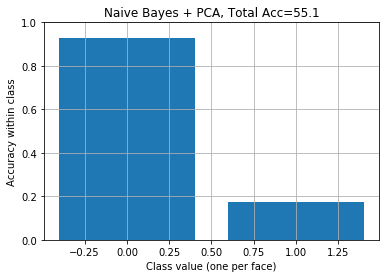

In [40]:
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB


# setup pipeline to take PCA, then fit a different classifier
clf_pipe = Pipeline(
    [('PCA',PCA(n_components=11,svd_solver='randomized')),
     ('CLF',GaussianNB())]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('Pipeline accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Naive Bayes + PCA")

In [41]:
from sklearn import metrics as mt

freq_infreq_threshold = 40

# get various measures of performance
total_accuracy = mt.accuracy_score(y, yhat)
per_class_acc_list = per_class_accuracy(y,yhat)

prec_for_freq_classes = []
recall_for_infreq_classes = []
rec_tot = []
prec_tot = []

for cls in np.unique(y):
    idx = (y==cls) # get classes
    ytmp_actual = np.zeros(y.shape) # make binary class problem
    ytmp_actual[idx] = 1 # set the instances for this specific class
    
    ytmp_predicted = np.zeros(y.shape) # binary prediction array
    ytmp_predicted[yhat==cls] = 1
    
    num_in_class = sum(idx)
    
    rec = mt.recall_score(ytmp_actual, ytmp_predicted)
    prec = mt.precision_score(ytmp_actual, ytmp_predicted)
    rec_tot.append(rec)
    prec_tot.append(prec)
    
    if num_in_class < freq_infreq_threshold:
        recall_for_infreq_classes.append(rec)
    elif num_in_class >= freq_infreq_threshold:
        prec_for_freq_classes.append(prec)
        
print ('Total Accuracy:',total_accuracy)
print ('Number of infrequent faces:',len(recall_for_infreq_classes), 
       'with average recall of:', np.mean(recall_for_infreq_classes))
print ('Number of frequent faces:',len(prec_for_freq_classes), 
       'with average precision of:',np.mean(prec_for_freq_classes))

Total Accuracy: 0.5509409474367294
Number of infrequent faces: 0 with average recall of: nan
Number of frequent faces: 2 with average precision of: 0.6168135404882085


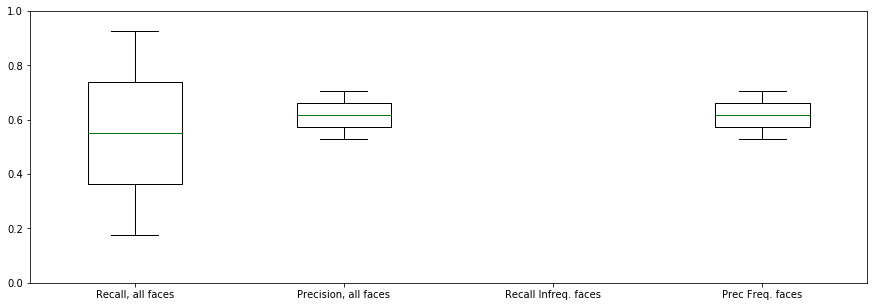

In [42]:
# But we can really summarize this data much better than this. 
# How about looking at more statistics of the precision and recall for each class?

import seaborn as sns
sns.set_palette("dark")
plt.figure(figsize=(15,5))
plt.boxplot([ rec_tot, prec_tot, recall_for_infreq_classes,prec_for_freq_classes],
            labels=['Recall, all faces','Precision, all faces','Recall Infreq. faces','Prec Freq. faces'])
plt.ylim([0,1])
plt.show()

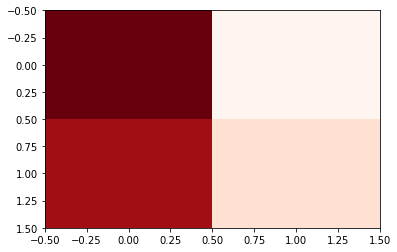

In [43]:
# how about plotting a confusion matrix?
cm = mt.confusion_matrix(y, yhat)
plt.imshow(cm,cmap=plt.get_cmap('Reds'),aspect='auto')
plt.grid(False)

- Nearestnearoids...etc

In [54]:
# from sklearn.naive_bayes import GaussianNB


# # setup pipeline to take PCA, then fit a different classifier
# clf_pipe = Pipeline(
#     [('PCA',PCA(n_components=11,svd_solver='randomized')),
#      ('CLF',GaussianNB())]
# )

# yhat_score = np.zeros((y.shape[0],len(X)))

# # now iterate through and get predictions, saved to the correct row in yhat
# for train, test in cv.split(X,y):
#     clf_pipe.fit(X[train],y[train])
#     yhat[test] = clf_pipe.predict(X[test])
#     yhat_score[test] = clf_pipe.predict_proba(X[test])

# total_accuracy = mt.accuracy_score(y, yhat)
# print ('Pipeline accuracy', total_accuracy)

In [56]:
# import seaborn as sns
# sns.set_palette("dark")
# # code manipulated from http://scikit-learn.org/stable/auto_examples/plot_roc.html
# from sklearn.preprocessing import label_binarize

# # Compute ROC curve for a subset of interesting classes
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in np.unique(y):
#     fpr[i], tpr[i], _ = mt.roc_curve(y, yhat_score[:, i], pos_label=i)
#     roc_auc[i] = mt.auc(fpr[i], tpr[i])

# for i in np.random.permutation(60)[0:6]:
#     plt.plot(fpr[i], tpr[i], label='class {0} with {1} instances (area = {2:0.2f})'
#                                    ''.format(i, sum(y==i), roc_auc[i]))

# plt.legend(loc="lower right")  
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.show()

In [58]:
# # combined ROC over all classes
# one_hot_class_encoding = label_binarize(y,np.unique(y))
# fpr["micro"], tpr["micro"], _ = mt.roc_curve(one_hot_class_encoding.ravel(), yhat_score.ravel())
# roc_auc["micro"] = mt.auc(fpr["micro"], tpr["micro"])

# plt.figure(figsize=(12,4))
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]))

# Classifier evaluation function

In [66]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

results = []

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv, model):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    
    results.append({'Model': model, 'Accuracy': Accavg, 'Precision': Preavg, 'Recall': Recavg})

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X, y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print (classReport)
    print (confMat)
    print (acc)

# Linear Regression

In [67]:
%%time

#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
#regGridSearch.fit(teamX, teamY)
regGridSearch.fit(df_inci_X_scaled, inci_Y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   20.6s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   23.1s finished


Wall time: 23.7 s


In [68]:
#Diplay the top model parameters
regGridSearch.best_estimator_.coef_

array([[ 0.01093505,  0.01216853, -0.01772629, -0.05387113, -0.09840126,
        -0.63512951,  0.20641006, -0.34168516,  0.03606739,  0.05396491,
         0.10961091]])

In [69]:
%%time

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
print("\n",round(EvaluateClassifierEstimator(classifierEst, df_inci_X_scaled, inci_Y, cv, "manual"),4))

#Use the best parameters for our Linear Regression object",
ClassiferParams = regGridSearch.best_params_
print("\n---- Logistic Regression - CV, Scaled 'Manual' Attr Elimination ----")
for keys,values in ClassiferParams.items():
    print(keys,": \t ",values)
    
# sort these attributes and spit them out\n",
name = inci_X
zip_vars = zip(regGridSearch.best_estimator_.coef_.T,name) # combine attributes
zip_vars = sorted(zip_vars, reverse=True)

# Print out Attributes and their weights\n",
print("\n---- Attributes and their weights -----\n")
for coef, name in zip_vars:
    print(name, ' has weight of', coef[0])

The average accuracy for all cv folds is: 			 0.66108
The average precision for all cv folds is: 			 0.67566
The average recall for all cv folds is: 			 0.61297
*********************************************************
Cross Validation Fold Mean Error Scores

    Accuracy  Precision  Recall
0    0.6620     0.6714  0.6345
1    0.6808     0.6966  0.6406
2    0.6795     0.6921  0.6466
3    0.6708     0.6836  0.6362
4    0.6635     0.6766  0.6263
5    0.6705     0.6862  0.6283
6    0.6757     0.6910  0.6357
7    0.6820     0.6921  0.6556
8    0.6729     0.6896  0.6287
9    0.5532     0.5774  0.3972

---- Logistic Regression - CV, Scaled 'Manual' Attr Elimination ----
C : 	  0.1
class_weight : 	  balanced
max_iter : 	  100
penalty : 	  l2
solver : 	  lbfgs

---- Attributes and their weights -----

Number_of_offense  has weight of 0.2064100596609839
Social_crime_score  has weight of 0.10961090510827184
IsMale  has weight of 0.05396490966659441
Call_Received_Hour  has weight of 0.036067391365

In [70]:

print("Best Estimator GridSearch Prediction")
print(regGridSearch.best_estimator_.predict(df_inci_X_scaled))
print(regGridSearch.best_estimator_.predict_proba(df_inci_X_scaled))

Best Estimator GridSearch Prediction
[0 0 0 ... 1 1 1]
[[0.54242639 0.45757361]
 [0.80506192 0.19493808]
 [0.64753909 0.35246091]
 ...
 [0.36470664 0.63529336]
 [0.40884151 0.59115849]
 [0.36760343 0.63239657]]


In [ ]:
# if 'Arrest_status' in incident:
#     y2 = incident['Arrest_status'].values # get the labels we want
#     del incident['Arrest_status'] # get rid of the class label
#     X2 = incident.values # use everything else to predict!

# LDA

In [73]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, GridSearchCV, ParameterGrid
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import metrics as mt

#Create Lists to Automate LDA Model Search
mySolv = ['lsqr', 'svd']
myNComponents = list(range(2,10,2))
myShrink = [None, 'auto']
parms = {'n_components': [myNComponents], 'solver': [mySolv]}
parmGrid = (list(ParameterGrid(parms)))
print(parmGrid)

#Create Target and Data sets
X = inci_X
y = inci_Y

#Save for M&E 4
XT1 = X
yT1 = y

#yhat = np.zeros(y.shape)
yhat = np.empty(y.shape,dtype=str)
yhat2 = np.empty(y.shape,dtype=str)

#Create cross validation interator
cv = StratifiedKFold(n_splits=10)
cv2 = StratifiedShuffleSplit(y, n_iter = 10, test_size = 0.2, train_size=0.8)

#Create arrays from data frame columns as input into dataframe iterators
X = X.values
y = y.values

### Parameter Grid Search for LDA and Stratified Shuffle Split
gscv = GridSearchCV(estimator=LinearDiscriminantAnalysis(), 
                   n_jobs=10, 
                   verbose=1, 
                   param_grid = parmGrid, 
                   scoring='accuracy')

for trainidx, testidx in cv2:
    X_train = X[trainidx] 
    X_test = X[testidx] 
    y_train = y[trainidx]
    y_test = y[testidx]    
    gscv.fit(X_train, y_train)
    print("GSCV CV2 LDA Accuracy:", gscv.score(X_test, y_test))

[{'n_components': [2, 4, 6, 8], 'solver': ['lsqr', 'svd']}]
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=10)]: Done  24 out of  24 | elapsed:    3.8s finished


GSCV CV2 LDA Accuracy: 0.6629894008219771
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=10)]: Done  24 out of  24 | elapsed:    3.8s finished


GSCV CV2 LDA Accuracy: 0.6594202898550725
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=10)]: Done  24 out of  24 | elapsed:    3.5s finished


GSCV CV2 LDA Accuracy: 0.6595284447328574
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=10)]: Done  24 out of  24 | elapsed:    3.6s finished


GSCV CV2 LDA Accuracy: 0.6561756435215228
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=10)]: Done  24 out of  24 | elapsed:    3.3s finished


GSCV CV2 LDA Accuracy: 0.6612589227774173
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=10)]: Done  24 out of  24 | elapsed:    3.3s finished


GSCV CV2 LDA Accuracy: 0.6586632057105776
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=10)]: Done  24 out of  24 | elapsed:    3.5s finished


GSCV CV2 LDA Accuracy: 0.6622323166774822
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=10)]: Done  24 out of  24 | elapsed:    3.8s finished


GSCV CV2 LDA Accuracy: 0.6658014276443868
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=10)]: Done  24 out of  24 | elapsed:    3.5s finished


GSCV CV2 LDA Accuracy: 0.6609344581440623
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=10)]: Done  24 out of  24 | elapsed:    4.0s finished


GSCV CV2 LDA Accuracy: 0.6605018386329223


In [76]:
# #Create LDA Object
# # clf = LinearDiscriminantAnalysis(n_components=2, priors=myPriors, solver='lsqr')
# # clf9 = LinearDiscriminantAnalysis(n_components=2, priors=myPriors, solver='svd')

# clf = LinearDiscriminantAnalysis(n_components=2, solver='lsqr')
# clf9 = LinearDiscriminantAnalysis(n_components=2,solver='svd')

# clf.fit(X_train, y_train)
# yhat2 = clf.predict(X_test)

# #print("LDA Component Coefficients:", clf.coef_)
# print(mt.classification_report(y_test, yhat2, target_names = [0,1]))

# from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC
# cm2 = ConfusionMatrix(clf, classes=[0,1], cmap='GnBu')
# cm2.fit(X_train, y_train)
# cm2.score(X_test, y_test)
# cm2.poof()

# crpt = ClassificationReport(clf, classes=[0,1], cmap='GnBu')
# crpt.fit(X_train, y_train)
# crpt.score(X_test, y_test)
# crpt.poof()

# MODELS

#### KNN Classification

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
import numpy as np
from sklearn import metrics as mt


X2 = inci_X.as_matrix().astype(np.float)
y2 = inci_Y.as_matrix().astype(np.float)
yhat2 = np.zeros(y2.shape)
# create variables we are more familiar with
# yhat2 = np.zeros(y2.shape) # we will fill this with predictions

# create cross validation iterator
cv = StratifiedKFold(y2, n_folds=10)

# get a handle to the classifier object, which defines the type
clf_K3 = KNeighborsClassifier(n_neighbors=3)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf_K3.fit(X2[train],y2[train])
    yhat2[test] = clf_K3.predict(X2[test])

#total_accuracy = mt.accuracy_score(y2, yhat2)
recall = mt.recall_score(y2[test], yhat2[test])
precision = mt.precision_score(y2[test], yhat2[test])
fscore = mt.f1_score(y2[test], yhat2[test])
#print('KNN accuracy is ', total_accuracy)
print('KNN recall is ', recall)
print('KNN precision is ', precision)

fscore = mt.f1_score(y2[test], yhat2[test])
print('Evaluation Metric: F-score is ', fscore)

KNN recall is  0.47987884032886197
KNN precision is  0.5564475664826894
Evaluation Metric: F-score is  0.5153345724907064


In [65]:
# yhat2 = np.zeros(y2.shape) # initializing variable

# for train, test in cv.split(X,y):
#     # Use Results parameters from GridSearch to run KNN Classifier model
#     clf_knn = KNeighborsClassifier(n_neighbors=11, weights='uniform',metric='minkowski', algorithm='auto',p=2,leaf_size=10)
#     clf_knn.fit(X2[train],y2[train])
#     yhat[test] = clf_knn.predict(X2[test])

# total_accuracy = mt.accuracy_score(y2, yhat2)
# #print KNN accuracy with corresponding parameter settings
# print('KNN classifier accuracy with optimal parameters is: %.3f'%(total_accuracy))

In [64]:

# from sklearn.metrics import confusion_matrix
# import itertools
# class_names = df['Primary'].unique()

# def plot_confusion_matrix(cm, classes,
#                           normalize=True,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     #print(cm)

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=0)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True Position label')
#     plt.xlabel('Predicted Position label')

# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y, yhat)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# #plt.figure()
# #plot_confusion_matrix(cnf_matrix, classes=class_names,
# #                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()